In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
import sklearn
from sklearn import preprocessing

import os
from os import path

In [ ]:
df_all = pd.DataFrame()
df_list = []

for folder in os.listdir():
    if not os.path.isdir(folder) or 'ipynb' in folder or folder == 'all_features':
        continue
    print(folder)
    df = pd.read_pickle(path.join(folder, 'regionprops_3d_extended.pkl'))
    df['condition'] = str(folder)
    df_list.append(df)

df_all = pd.concat(df_list)



JC_Plate3_high_3


In [ ]:
df_all.to_pickle('dataframe_labeled.pkl')

In [ ]:
del df_all

In [ ]:
df_all=pd.read_pickle('dataframe_labeled.pkl')

In [ ]:
df_all.iloc[0].condition

In [ ]:
df_all['condition'] = df_all['condition'].apply(lambda x: '_'.join(x.rsplit('_')[2:]))
df_all.iloc[0].condition

df = df_all

In [ ]:
std_lower = np.std(df[df.area < np.percentile(df.area, 50)].area)
std_upper = np.std(df[df.area > np.percentile(df.area, 50)].area)

In [ ]:
sns.displot(df.area)
plt.axvline(x=np.median(df.area) +  1.5*std_upper, color='r', linestyle='--')
plt.axvline(x=np.median(df.area) -  1.5*std_lower, color='r', linestyle='--')


plt.title('Distribution of area')
plt.xlabel('area')
plt.ylabel('absolute frequency')
plt.show()

In [ ]:
df = df[(df.area >= (np.median(df.area) - 1.5 * std_lower)) & (df.area <= (np.median(df.area) +  1.5*std_upper))]

In [ ]:
sns.displot(df.area)

plt.title('Distribution of area')
plt.xlabel('area')
plt.ylabel('absolute frequency')


In [ ]:
sns.displot(df.bbox_area)
plt.axvline(x=np.percentile(df.bbox_area, 97.5), color='r', linestyle='--')

plt.title('Distribution of bbox_area')
plt.xlabel('bbox_area')
plt.ylabel('absolute frequency')


In [ ]:
df = df[df.bbox_area <= np.percentile(df.bbox_area, 97.5)]


In [ ]:
sns.displot(df.area)

plt.title('Distribution of area')
plt.xlabel('area')
plt.ylabel('absolute frequency')


In [ ]:
image_features = ['image', 'slice', 'intensity_image', 'convex_image']
df_images = df[image_features]
df = df.drop(columns=image_features)
df_images.to_pickle('dataframe_images.pkl')
df.to_pickle('dataframe_no_images.pkl')

In [ ]:
del df_images
del df

In [ ]:
df = pd.read_pickle('dataframe_no_images.pkl')
df = df.reset_index(drop=True)

In [ ]:
columns = df.columns[0:-1]
df[columns] = df[columns].apply(pd.to_numeric, errors='ignore')

In [ ]:
columns = df.columns[0:-1]
df[columns] = df[columns].applymap(lambda x: x[0] if isinstance(x, np.ndarray) and len(x) > 0 else x)
#some entries are of dtype np.ndarray but only contain one value - extracting this value

In [ ]:
cols = [col for col in df.columns if ('bbox' not in col and 'centroid' not in col and 'coords' not in col and 'label' not in col) or ('local' in col)]
df = df[cols]
#drop features with no biological relevance

In [ ]:
df[df.isin([np.inf, -np.inf]).any(axis=1)]

In [ ]:
df = df[~df.isin([np.inf, -np.inf]).any(axis=1)]
df
#remove nuclei with inf values (only 1 so just remove)

In [ ]:
df.to_pickle('dataframe_cleaned.pkl')

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = pd.read_pickle('dataframe_cleaned.pkl')
df = df.reset_index(drop=True)

condition = df['condition'].reset_index(drop=True)
features = df.drop(columns=['condition']).reset_index(drop=True)

scaler = StandardScaler()  # Scale features to range from 0 to 1
df_normalized = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

# Concatenate the condition column back to the normalized features DataFrame
df_normalized = pd.concat([condition, df_normalized], axis=1)

df_normalized.to_pickle('dataframe_normalized.pkl')
del df_normalized

In [ ]:
from sklearn.impute import KNNImputer

df = pd.read_pickle('dataframe_normalized.pkl')
#Drop fully empty features
df = df.dropna(axis=1, how='all')

condition = df['condition'].reset_index(drop=True)
features = df.drop(columns=['condition']).reset_index(drop=True)

imputer = KNNImputer(n_neighbors=5, keep_empty_features=True)
features_imputed = pd.DataFrame(imputer.fit_transform(features), columns=features.columns)

df_imputed = pd.concat([features_imputed, condition], axis=1, ignore_index=False)

print(features_imputed.shape, condition.shape)

In [ ]:
df_imputed.columns[df_imputed.isna().any()]

In [ ]:
df_imputed

In [ ]:
df_imputed.to_pickle('dataframe_knn_imputed.pkl')

<h4> Random Forest Classifier </h4>

In [2]:
def plot_feature_importances(feature_importances):
    top20 = feature_importances['Feature Importance'].nlargest(20)
    plt.figure(figsize=(10, 6))
    plt.barh(top20.index, top20.values, align='center')
    plt.yticks(top20.index, top20.index)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Top 20 Feature Importances')
    plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
    plt.show()
    
def plot_confusion_matrix(cf):
    sns.heatmap(cf, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

def plot_accuracies(df_ac):
    plt.figure(figsize=(10, 6))
    plt.bar(df_ac['Model'], df_ac['Accuracy'])
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Accuracies for RFCs')
    plt.tight_layout()  
    plt.xticks(rotation=90)
    plt.show()

def all_possible_rfc(df, output_dir, kfold = 20, n_jobs = 1, compute_pairs=False, param_grid=None, n_estimators=100):

    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import KFold
    from sklearn.metrics import confusion_matrix
    from sklearn.model_selection import GridSearchCV
    import numpy as np 
    import pandas as pd
    from os.path import join
    import itertools

    !mkdir -p $output_dir

    accuracies_df = pd.DataFrame()


    columns = df.columns[0:-1]
    X = df[columns].to_numpy()
    y = df.condition.to_numpy()

    model = RandomForestClassifier(criterion="entropy", n_estimators=n_estimators, n_jobs=n_jobs)

    if param_grid:
        grid_search = GridSearchCV(model, param_grid, cv=kfold, n_jobs=n_jobs)
        grid_search.fit(X, y)
        best_params = grid_search.best_params_
        print("Best Parameters:", best_params)
        model = grid_search.best_estimator_

    kfold = KFold(n_splits=kfold, shuffle=True, random_state=42)  # Adjust the number of splits as needed
    accuracies = []
    train_acc = []
    feature_importances = np.zeros(X.shape[1])  # Initialize array to store feature importances
    confusion_matrices = []

    for train_index, test_index in kfold.split(X):
        X_train, X_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        train_acc.append(model.score(X_train, y_train))

        # Evaluate the model
        accuracy = model.score(X_val, y_val)
        accuracies.append(accuracy)

        # Predict on validation set
        y_pred = model.predict(X_val)

        # Calculate confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        confusion_matrices.append(cm)

        # Accumulate feature importances
        feature_importances += model.feature_importances_

    average_accuracy = np.mean(accuracies)
    avg_train_acc = np.mean(train_acc)
    accuracies_df = pd.concat([accuracies_df, pd.DataFrame({'Model': ['all'], 'Accuracy': [average_accuracy], 'Train-Accuracy': [avg_train_acc]})], ignore_index=True)
    print("Average Train Accuracy:", avg_train_acc)
    print("Average Accuracy:", average_accuracy)

    # Calculate average confusion matrix
    average_confusion_matrix = np.mean(confusion_matrices, axis=0)
    
    # Normalize the confusion matrix
    sum_true_positives = average_confusion_matrix.sum(axis=1, keepdims=True)
    normalized_confusion_matrix = average_confusion_matrix / sum_true_positives
    
    # Display normalized confusion matrix as DataFrame
    confusion_matrix_df = pd.DataFrame(normalized_confusion_matrix, columns=model.classes_, index=model.classes_)
    confusion_matrix_df.to_pickle(join(output_dir, 'confusion_matrix.pkl'))
    
    # Average feature importances across all folds
    average_feature_importances = feature_importances / kfold.n_splits
    
    # Create DataFrame for feature importances
    feature_importance_df = pd.DataFrame(average_feature_importances, columns=["Feature Importance"], index=columns)
    feature_importance_df.to_pickle(join(output_dir, 'feature_importance.pkl'))

    plot_feature_importances(feature_importance_df)
    plot_confusion_matrix(confusion_matrix_df)

    if compute_pairs:
        # Generate all possible combinations of pairs
        conditions = set(df.condition)
        pairs = set()
        for pair in itertools.combinations(conditions, 2):
            pairs.add(tuple(sorted(pair)))
        pairs = list(pairs)
       
        for pair in pairs:
            foldername = pair[0] + '-' + pair[1]
            foldername = join(output_dir, foldername)
            print(foldername)
            !mkdir -p $foldername
            df_curr = df[(df['condition'] == pair[0]) | (df['condition'] == pair[1])]
        
            X = df_curr[columns].to_numpy()
            y = df_curr.condition.to_numpy()
    
            accuracies = []
            train_acc = []
            feature_importances = np.zeros(X.shape[1])  # Initialize array to store feature importances
            confusion_matrices = []
            
            for train_index, test_index in kfold.split(X):
                X_train, X_val = X[train_index], X[test_index]
                y_train, y_val = y[train_index], y[test_index]
            
                model.fit(X_train, y_train)
                train_acc.append(model.score(X_train, y_train))
                
                # Evaluate the model
                accuracy = model.score(X_val, y_val)
                accuracies.append(accuracy)
                
                # Predict on validation set
                y_pred = model.predict(X_val)
                
                # Calculate confusion matrix
                cm = confusion_matrix(y_val, y_pred)
                confusion_matrices.append(cm)
                
                # Accumulate feature importances
                feature_importances += model.feature_importances_
            
            average_accuracy = np.mean(accuracies)
            avg_train_acc = np.mean(train_acc)
            accuracies_df = pd.concat([accuracies_df, pd.DataFrame({'Model': [foldername.rsplit('/')[-1]], 'Accuracy': [average_accuracy], 'Train-Accuracy': [avg_train_acc]})], ignore_index=True)
            print("Average Accuracy:", average_accuracy)
            
            # Calculate average confusion matrix
            average_confusion_matrix = np.mean(confusion_matrices, axis=0)
            
            # Normalize the confusion matrix
            sum_true_positives = average_confusion_matrix.sum(axis=1, keepdims=True)
            normalized_confusion_matrix = average_confusion_matrix / sum_true_positives
            
            # Display normalized confusion matrix as DataFrame
            confusion_matrix_df = pd.DataFrame(normalized_confusion_matrix, columns=model.classes_, index=model.classes_)
            confusion_matrix_df.to_pickle(join(foldername,'confusion_matrix.pkl'))
            
            # Average feature importances across all folds
            average_feature_importances = feature_importances / kfold.n_splits
            
            # Create DataFrame for feature importances
            feature_importance_df = pd.DataFrame(average_feature_importances, columns=["Feature Importance"], index=columns)
            feature_importance_df.to_pickle(join(foldername,'feature_importance.pkl'))
    
        plot_accuracies(accuracies_df)

    

<h4>Correlation filtering</h4>

In [3]:
#https://www.kaggle.com/code/oldwine357/removing-highly-correlated-features/notebook

def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)
    print('Removed Columns {}'.format(drops))
    return (x,drops)

In [4]:
df = pd.read_pickle('dataframe_knn_imputed.pkl')

condition = df['condition'].reset_index(drop=True)
features = df.drop(columns=['condition']).reset_index(drop=True)

features, drops = remove_collinear_features(features,0.80)

df_dropped = pd.concat([features, condition], axis=1, ignore_index=False)


Removed Columns {'weighted_local_centroid-0', 'moments_normalized-0-3-1', 'weighted_moments_normalized-2-1-3', 'weighted_moments-1-3-3', 'weighted_moments_central-2-3-3', 'weighted_moments_normalized-1-2-0', 'weighted_moments_normalized-3-0-3', 'hc_foci_ratio_d2b_volume_mean', 'weighted_moments_normalized-1-1-1', 'moments_central-2-2-3', 'moments-3-3-3', 'int_mean', 'weighted_moments-2-2-3', 'dissimilarity_20', 'moments-1-2-3', 'weighted_moments_central-3-0-2', 'moments-1-3-0', 'weighted_moments-3-0-3', 'weighted_moments_normalized-2-3-0', 'weighted_moments_central-1-0-1', 'moments_central-2-1-1', 'weighted_moments_central-3-0-1', 'weighted_moments_central-0-3-2', 'weighted_moments_central-0-0-3', 'weighted_moments-0-1-2', 'moments-0-3-2', 'weighted_moments_central-0-2-0', 'weighted_moments-0-2-3', 'moments-2-0-0', 'moments_normalized-3-0-1', 'moments-1-3-2', 'moments_central-3-1-0', 'weighted_moments_normalized-1-0-1', 'moments-0-3-0', 'weighted_moments_central-0-3-1', 'weighted_momen

In [5]:
print(len(drops))
df_dropped.to_pickle('dataframe_dropped.pkl')

401


In [6]:
df_dropped

,convex_area,euler_number,extent,inertia_tensor-0-1,inertia_tensor-0-2,inertia_tensor-1-1,inertia_tensor-1-2,inertia_tensor-2-2,local_centroid-0,max_intensity,...,rd_9,hc_foci_count,hc_foci_volume_mean,hc_foci_mean_intensity_variance,hc_foci_d2b_mean,hc_foci_d_nearest_neighbor_mean,hc_foci_d_nearest_neighbor_variance,hc_foci_d_nearest_neighbor(verts)_mean,hc_foci_d_nearest_neighbor(verts)_variance,condition
0,-1.159654,0.073347,-1.098610,-0.595965,2.886758,-0.310074,-0.114300,-1.883863,0.410078,0.0,...,-1.726700,-0.595579,-0.208453,1.737827,-0.300799,-1.057157,-1.579075,-0.621446,-0.782213,high_3
1,0.733708,0.073347,1.905785,0.510526,0.192538,1.003606,-0.419577,-0.093769,0.248176,0.0,...,-0.642179,2.274619,-1.148128,-0.205207,0.262972,-1.018795,-0.988323,-0.624287,-0.839256,high_3
2,0.516758,0.073347,-0.254342,0.211896,1.139213,0.886826,-1.985424,-0.199048,0.678345,0.0,...,-0.077331,-0.264403,0.152048,0.741566,-0.525511,0.133739,-0.397329,-0.092377,0.084390,high_3
3,1.042588,0.073347,-0.077322,0.873604,-1.858762,2.491122,0.542690,0.139510,-0.198126,0.0,...,0.825972,-0.264403,0.033952,-0.649148,0.598219,0.008319,1.275614,-0.114447,0.248967,high_3
4,-0.293713,0.073347,-0.921672,-0.466198,1.375862,-0.182623,0.752739,0.789779,-0.434266,0.0,...,0.834794,0.729128,-0.830424,0.147527,-0.928807,-0.665957,-0.299505,0.167866,-0.603014,high_3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2331,-1.440774,0.073347,1.124795,-1.015043,-0.578932,-0.492794,0.188284,-0.678347,-1.616054,0.0,...,-0.467666,-0.154010,-0.712907,-0.576813,-0.350634,-0.360739,-0.696436,-0.147361,-0.286123,control_2
2332,-0.161803,0.073347,0.671272,0.970282,-0.917296,-0.470838,-1.433015,0.510862,-0.039732,0.0,...,0.502363,0.177166,-0.448612,0.317219,-0.122233,0.011215,-1.110671,-0.399037,-0.719161,control_2
2333,0.509918,0.073347,0.071206,2.446567,0.745440,0.387893,-1.188114,0.378213,0.314961,0.0,...,-0.034426,0.177166,-0.334800,-0.909753,0.275791,-1.305519,-1.053517,-1.218180,-1.141082,control_2
2334,-0.105327,0.073347,-1.795050,-0.906340,1.154342,-0.120564,2.003279,-0.194005,0.354811,0.0,...,1.664887,0.066774,-0.046542,0.914373,-0.903897,-1.500369,0.908191,0.202286,0.060800,control_2


In [ ]:
# Shapiro-Wilk test for normality
for condition, group_data in df.groupby('condition')['mean_intensity']:
    stat, p = stats.shapiro(group_data)
    print(f"Shapiro-Wilk test for {condition}:")
    print(f"  Test statistic: {stat:.4f}, p-value: {p:.4f}")
    if p > 0.05:
        print("  Data appears to be normally distributed (fail to reject H0)")
    else:
        print("  Data does not appear to be normally distributed (reject H0)")


control_1 control_2 1.4218264222159005e-63 **** -0.842720072476699
control_1 control_3 2.956216757559391e-60 **** -0.8661053775122216
control_2 control_3 0.4227046085768224 n.s. -0.0939595152140279
high_1 high_2 1.0 n.s. -0.04634689334142883
high_1 high_3 0.018388402846590192 * -0.14975789043813081
high_2 high_3 0.15899807000606436 n.s. -0.11234128553227007


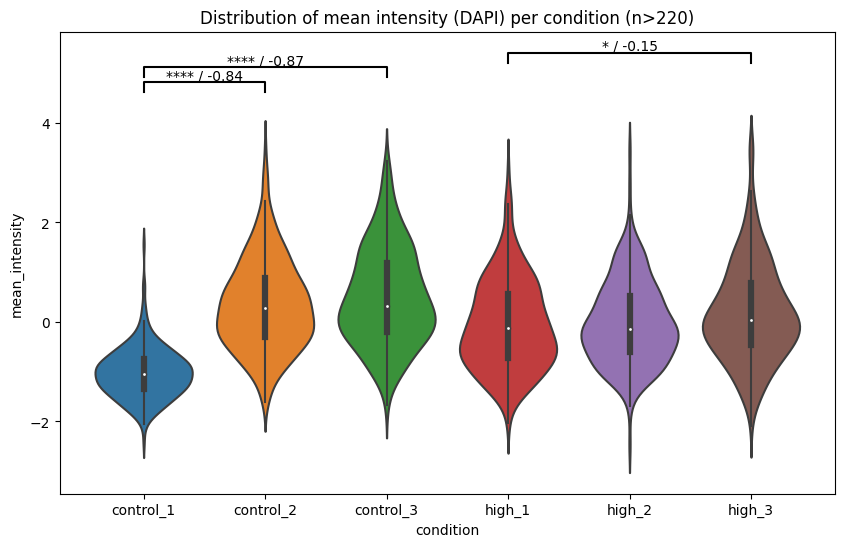

In [54]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import itertools
from statsmodels.stats.multitest import multipletests

# Load the dataframe
df = pd.read_pickle('dataframe_dropped.pkl')
min_sample_size = df.groupby('condition').size().min()

# Define a function to perform Mann-Whitney U test and calculate rank-biserial correlation
def mannwhitneyu_test(group1, group2):
    u_statistic, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
    rank_biserial_corr = (2 * u_statistic / (len(group1) * len(group2))) - 1
    return p_value, u_statistic, rank_biserial_corr

# Generate all pairwise comparisons
pairs_controls = list(itertools.combinations(controls, 2))
pairs_highs = list(itertools.combinations(highs, 2))

# Generate combinations of controls (excluding control_1) and highs
controls_excluding_control1 = [c for c in controls if c != 'control_1']
pairs_controls_highs = list(itertools.product(controls_excluding_control1, highs))

# Collect p-values, U statistics, and rank-biserial correlations from all comparisons
p_values = []
u_statistics = []
rank_biserial_corrs = []
all_pairs = pairs_controls + pairs_highs

for (cond1, cond2) in all_pairs:
    data1 = df[df['condition'] == cond1]['mean_intensity']
    data2 = df[df['condition'] == cond2]['mean_intensity']
    p_value, u_statistic, rank_biserial_corr = mannwhitneyu_test(data1, data2)
    p_values.append(p_value)
    u_statistics.append(u_statistic)
    rank_biserial_corrs.append(rank_biserial_corr)

# Apply Bonferroni correction
_, corrected_p_values, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

# Map corrected p-values, U statistics, and rank-biserial correlations back to the pairs
results = {
    'Condition 1': [],
    'Condition 2': [],
    'Corrected P-Value': [],
    'U Statistic': [],
    'Rank-biserial Correlation': []
}

for (cond1, cond2), p_val, u_stat, rank_corr in zip(all_pairs, corrected_p_values, u_statistics, rank_biserial_corrs):
    results['Condition 1'].append(cond1)
    results['Condition 2'].append(cond2)
    results['Corrected P-Value'].append(p_val)
    results['U Statistic'].append(u_stat)
    results['Rank-biserial Correlation'].append(rank_corr)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save results to CSV
results_df.to_csv('mannwhitneyu_results.csv', index=False)


# Plot the violin plot
plt.figure(figsize=(10,6))
df['condition'] = pd.Categorical(df['condition'], categories=controls + highs)
sns.violinplot(data=df, x='condition', y='mean_intensity', hue='condition', dodge=False, legend=False)
plt.legend().remove()
plt.title(f'Distribution of mean intensity (DAPI) per condition (n>{round(min_sample_size,-1)})')

# Add significance stars and rank-biserial correlation for controls
y_max = df['mean_intensity'].max() + 0.2
h = 0.2  # height of the significance bars
col = 'k'  # color of the significance bars

# Initialize the y-position for the first set of significance bars
y_position = y_max

# Function to add significance bars and stars
def add_significance_bars(pairs):
    global y_position
    for (cond1, cond2) in pairs:
        x1, x2 =  df['condition'].cat.categories.tolist().index(cond1), df['condition'].cat.categories.tolist().index(cond2)
        stars = get_significance_stars(corrected_p_values_dict[(cond1, cond2)])
        rank_biserial_corr = rank_biserial_corrs_dict[(cond1, cond2)]
        print(cond1, cond2, corrected_p_values_dict[(cond1, cond2)], stars, rank_biserial_corr)
        if stars != "n.s.":
            y = y_position + h
            plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
            plt.text((x1 + x2) * .5, y + h, f'{stars} / {rank_biserial_corr:.2f}', ha='center', va='bottom', color=col)
            y_position += h * 1.5  # Increment y-position for the next bar

# Add significance bars for controls and highs
add_significance_bars(pairs_controls)
#y_position = y_max  # Reset y-position for high comparisons
add_significance_bars(pairs_highs)

plt.show()


control_1 control_2 2.843652844431801e-63 **** -0.842720072476699
control_1 control_3 5.912433515118782e-60 **** -0.8661053775122216
control_2 control_3 0.8454092171536448 n.s. -0.0939595152140279
high_1 high_2 1.0 n.s. -0.04634689334142883
high_1 high_3 0.036776805693180384 * -0.14975789043813081
high_2 high_3 0.3179961400121287 n.s. -0.11234128553227007


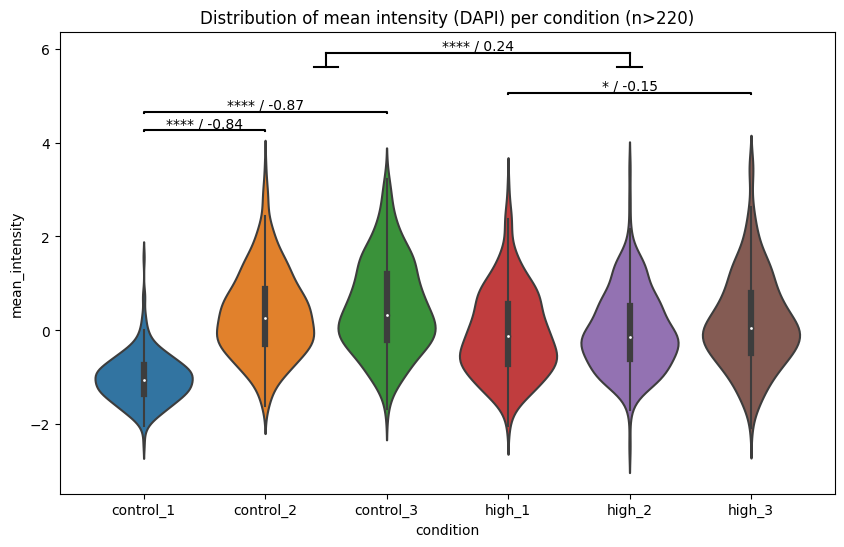

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import itertools
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataframe
df = pd.read_pickle('dataframe_dropped.pkl')
min_sample_size = df.groupby('condition').size().min()

# Define a function to perform Mann-Whitney U test and calculate rank-biserial correlation
def mannwhitneyu_test(group1, group2):
    u_statistic, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
    rank_biserial_corr = (2 * u_statistic / (len(group1) * len(group2))) - 1
    return p_value, u_statistic, rank_biserial_corr

# Prepare the data
controls = ['control_1', 'control_2', 'control_3']
highs = ['high_1', 'high_2', 'high_3']

# Generate all pairwise comparisons
pairs_controls = list(itertools.combinations(controls, 2))
pairs_highs = list(itertools.combinations(highs, 2))
controls_excluding_control1 = [c for c in controls if c != 'control_1']
pairs_controls_highs = list(itertools.product(controls_excluding_control1, highs))

# Collect p-values, U statistics, and rank-biserial correlations from all comparisons
p_values = []
u_statistics = []
rank_biserial_corrs = []

all_pairs = pairs_controls + pairs_highs + pairs_controls_highs

for (cond1, cond2) in all_pairs:
    data1 = df[df['condition'] == cond1]['mean_intensity']
    data2 = df[df['condition'] == cond2]['mean_intensity']
    p_value, u_statistic, rank_biserial_corr = mannwhitneyu_test(data1, data2)
    p_values.append(p_value)
    u_statistics.append(u_statistic)
    rank_biserial_corrs.append(rank_biserial_corr)

# Apply Bonferroni correction to individual p-values
_, corrected_p_values, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

# Dictionary to map pairs to their corrected p-values and rank-biserial correlations
corrected_p_values_dict = {pair: corrected_p_values[i] for i, pair in enumerate(all_pairs)}
rank_biserial_corrs_dict = {pair: rank_biserial_corrs[i] for i, pair in enumerate(all_pairs)}

# Aggregate corrected p-values using Fisher's method for control-high comparisons
p_values_ch = [corrected_p_values_dict[(cond1, cond2)] for cond1, cond2 in pairs_controls_highs]

fisher_combined_p = stats.combine_pvalues(p_values_ch)[1]

# Calculate average rank-biserial correlation for control-high comparisons
r_ch = [rank_biserial_corrs_dict[(cond1, cond2)] for cond1, cond2 in pairs_controls_highs]
avg_r = np.mean(r_ch)

# Store results in a DataFrame
results = {
    'Condition 1': [],
    'Condition 2': [],
    'Corrected P-Value': [],
    'U Statistic': [],
    'Rank-biserial Correlation': []
}

for (cond1, cond2), p_val, u_stat, rank_corr in zip(all_pairs, corrected_p_values, u_statistics, rank_biserial_corrs):
    results['Condition 1'].append(cond1)
    results['Condition 2'].append(cond2)
    results['Corrected P-Value'].append(p_val)
    results['U Statistic'].append(u_stat)
    results['Rank-biserial Correlation'].append(rank_corr)

# Add control-high comparison to results
results['Condition 1'].append('control')
results['Condition 2'].append('high')
results['Corrected P-Value'].append(fisher_combined_p)
results['U Statistic'].append('-')
results['Rank-biserial Correlation'].append(avg_r)

results_df = pd.DataFrame(results)

# Save results to CSV
results_df.to_csv('mannwhitneyu_results.csv', index=False)

# Plot the violin plot
plt.figure(figsize=(10, 6))
df['condition'] = pd.Categorical(df['condition'], categories=controls + highs)
sns.violinplot(data=df, x='condition', y='mean_intensity', hue='condition', dodge=False, legend=False)
plt.legend().remove()
plt.title(f'Distribution of mean intensity (DAPI) per condition (n>{round(min_sample_size, -1)})')

# Define a function to add significance bars and stars
def get_significance_stars(p_val):
    if p_val < 0.0001:
        return '****'
    elif p_val < 0.001:
        return '***'
    elif p_val < 0.01:
        return '**'
    elif p_val < 0.05:
        return '*'
    else:
        return 'n.s.'

def add_significance_bars(pairs, y_position, h=0.02, col='k'):
    for (cond1, cond2) in pairs:
        x1, x2 = df['condition'].cat.categories.tolist().index(cond1), df['condition'].cat.categories.tolist().index(cond2)
        stars = get_significance_stars(corrected_p_values_dict[(cond1, cond2)])
        rank_biserial_corr = rank_biserial_corrs_dict[(cond1, cond2)]
        print(cond1, cond2, corrected_p_values_dict[(cond1, cond2)], stars, rank_biserial_corr)
        if stars != "n.s.":
            y = y_position + h
            plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
            plt.text((x1 + x2) * .5, y + h, f'{stars} / {rank_biserial_corr:.2f}', ha='center', va='bottom', color=col)
            y_position += h * 20  # Increment y-position for the next bar
    return y_position

# Add significance bars for controls and highs
y_position = df['mean_intensity'].max()
y_position = add_significance_bars(pairs_controls, y_position)
y_position = add_significance_bars(pairs_highs, y_position)

# Add significance bar for control-high comparison with whiskers
x_control = np.mean([df['condition'].cat.categories.tolist().index('control_3'), df['condition'].cat.categories.tolist().index('control_2')])
x_high = np.mean([df['condition'].cat.categories.tolist().index('high_1'), df['condition'].cat.categories.tolist().index('high_2'), df['condition'].cat.categories.tolist().index('high_3')])
stars = get_significance_stars(fisher_combined_p)
h=0
y_position += h / 2
y_position += 0.5
plt.plot([x_control, x_control, x_high, x_high], [y_position, y_position + h, y_position + h, y_position], lw=1.5, c='k')
plt.text((x_control + x_high) * .5, y_position + h, f'{stars} / {avg_r:.2f}', ha='center', va='bottom', color='k')

# Add horizontal whiskers
whisker_length = 0.1
plt.plot([x_control-whisker_length, x_control + whisker_length], [y_position - 0.3, y_position - 0.3], lw=1.5, c='k')
plt.plot([x_high-whisker_length, x_high + whisker_length], [y_position - 0.3, y_position - 0.3], lw=1.5, c='k')
plt.plot([x_control, x_control], [y_position, y_position - 0.3], lw=1.5, c='k')
plt.plot([x_high, x_high], [y_position, y_position - 0.3], lw=1.5, c='k')



plt.show()


In [1]:
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt

<h5>Predicting on third batch - checking all combinations</h5>

In [7]:
def plot_confusion_matrix(cf):
    sns.heatmap(cf, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

def plot_feature_importances(feature_importances):
    top20 = feature_importances['Feature Importance'].nlargest(20)
    plt.figure(figsize=(10, 6))
    plt.barh(top20.index, top20.values, align='center')
    plt.yticks(top20.index, top20.index)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Top 20 Feature Importances')
    plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
    plt.show()

In [18]:
df = pd.read_pickle('dataframe_dropped.pkl')
df1 = df[df['condition'].isin(['control_1', 'low_1', 'high_1'])]
df2 = df[df['condition'].isin(['control_2', 'low_2', 'high_2'])]
df3 = df[df['condition'].isin(['control_3', 'low_3', 'high_3'])]

In [19]:
df1['condition'] = df1['condition'].apply(lambda x: x.rsplit('_')[0])
df2['condition'] = df2['condition'].apply(lambda x: x.rsplit('_')[0])
df3['condition'] = df3['condition'].apply(lambda x: x.rsplit('_')[0])

/tmp/ipykernel_444275/73303980.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['condition'] = df1['condition'].apply(lambda x: x.rsplit('_')[0])
/tmp/ipykernel_444275/73303980.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['condition'] = df2['condition'].apply(lambda x: x.rsplit('_')[0])
/tmp/ipykernel_444275/73303980.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

Average Train Accuracy: 1.0
Average Accuracy: 0.5158012820512822


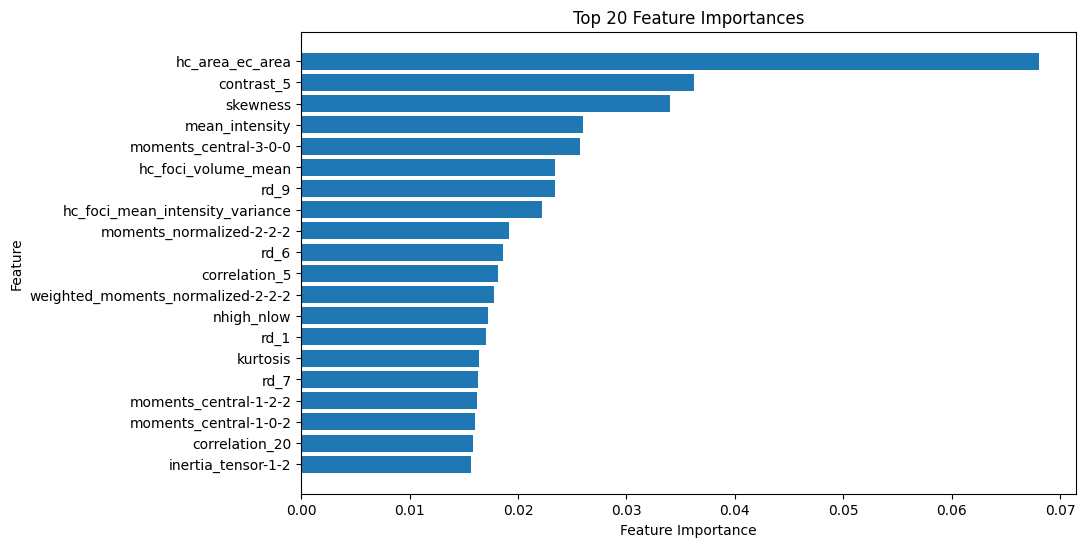

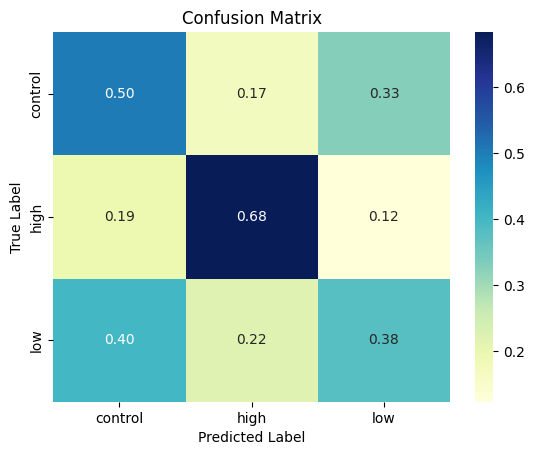

In [10]:
all_possible_rfc(df2, 'test', compute_pairs = False, n_jobs=8)

Average Train Accuracy: 1.0
Average Accuracy: 0.5326602564102564


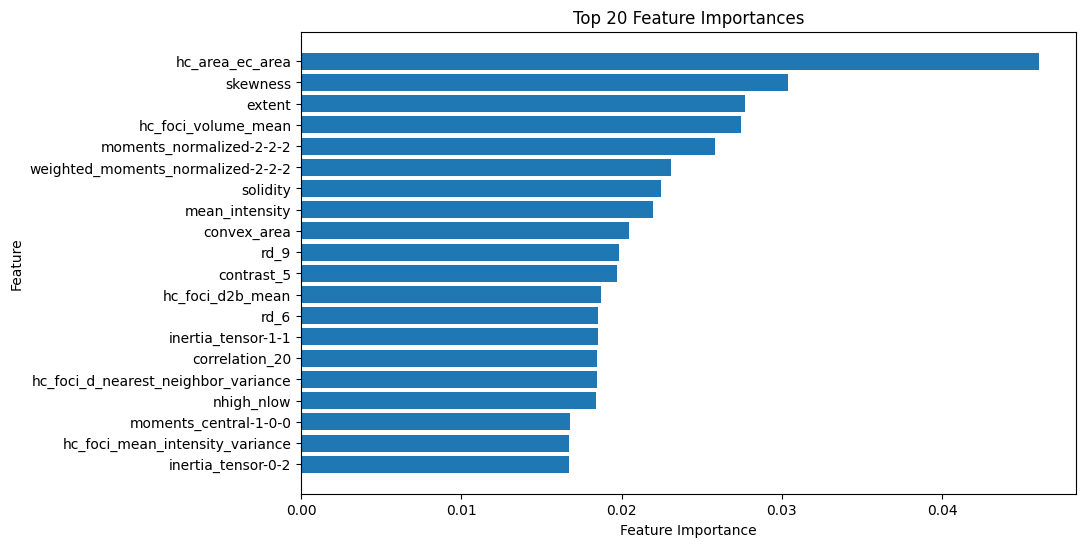

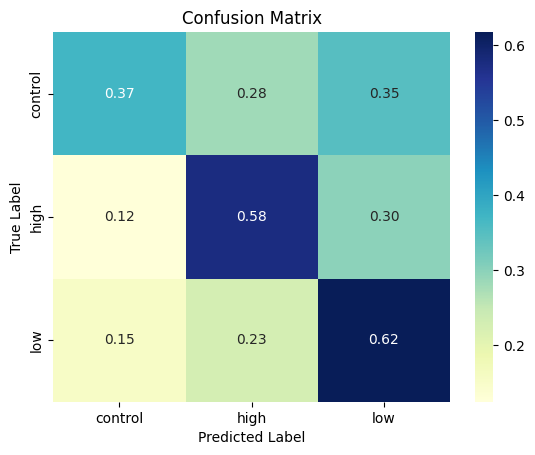

In [11]:
all_possible_rfc(df3, 'test', compute_pairs = False, n_jobs=8)

Average Train Accuracy: 1.0
Average Accuracy: 0.5494665718349928


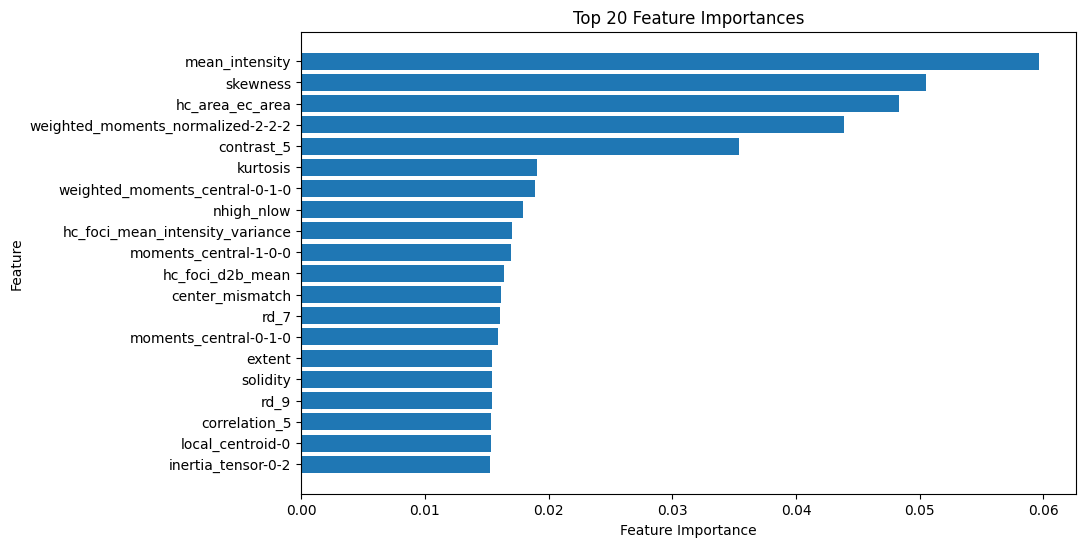

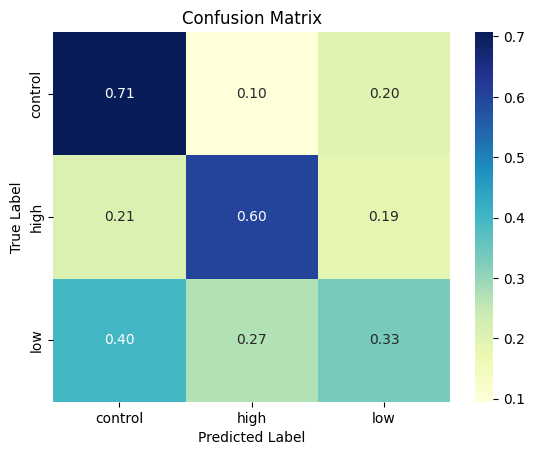

In [12]:
all_possible_rfc(df1, 'test', compute_pairs = False, n_jobs=8)

In [20]:
df_train = pd.concat([df2,df3], axis=0)
print(df2.shape, df3.shape, df_train.shape)
df_train.head()

(787, 67) (790, 67) (1577, 67)


,convex_area,euler_number,extent,inertia_tensor-0-1,inertia_tensor-0-2,inertia_tensor-1-1,inertia_tensor-1-2,inertia_tensor-2-2,local_centroid-0,max_intensity,...,rd_9,hc_foci_count,hc_foci_volume_mean,hc_foci_mean_intensity_variance,hc_foci_d2b_mean,hc_foci_d_nearest_neighbor_mean,hc_foci_d_nearest_neighbor_variance,hc_foci_d_nearest_neighbor(verts)_mean,hc_foci_d_nearest_neighbor(verts)_variance,condition
1073,0.752667,0.073347,0.494237,1.700908,-1.107791,0.337510,0.222205,0.870901,0.461112,0.0,...,-0.619926,-0.154010,0.516800,-0.917620,1.299392,0.672117,-0.198752,-0.048841,0.100579,low
1074,-1.041624,0.073347,-1.935919,-0.474258,0.910276,0.546183,-0.804316,-1.700935,0.312471,0.0,...,1.181238,0.066774,-0.777663,0.444867,-1.287896,-0.437168,0.325923,-1.010322,-0.475098,low
1075,-0.969508,0.073347,0.918068,0.376153,-0.618708,-1.081563,-0.154827,-0.201476,-0.760071,0.0,...,0.362715,1.170697,-1.205422,0.187896,-0.147260,-0.989260,-0.958447,-0.920427,-0.846802,low
1076,1.058631,0.073347,1.017865,0.943006,0.499717,-0.054957,1.149883,0.623041,0.924073,0.0,...,-0.799645,0.839520,-0.304730,-0.847735,2.430468,-0.193766,0.151950,0.597813,0.921066,low
1077,1.474226,0.073347,1.170231,0.085365,-0.356031,1.549333,-0.821299,0.246763,0.310538,0.0,...,-0.821850,0.066774,0.583416,-0.360327,0.466612,-0.096071,-0.126107,0.692388,0.242256,low


Average Train Accuracy: 1.0
Average Accuracy: 0.47302823758519963


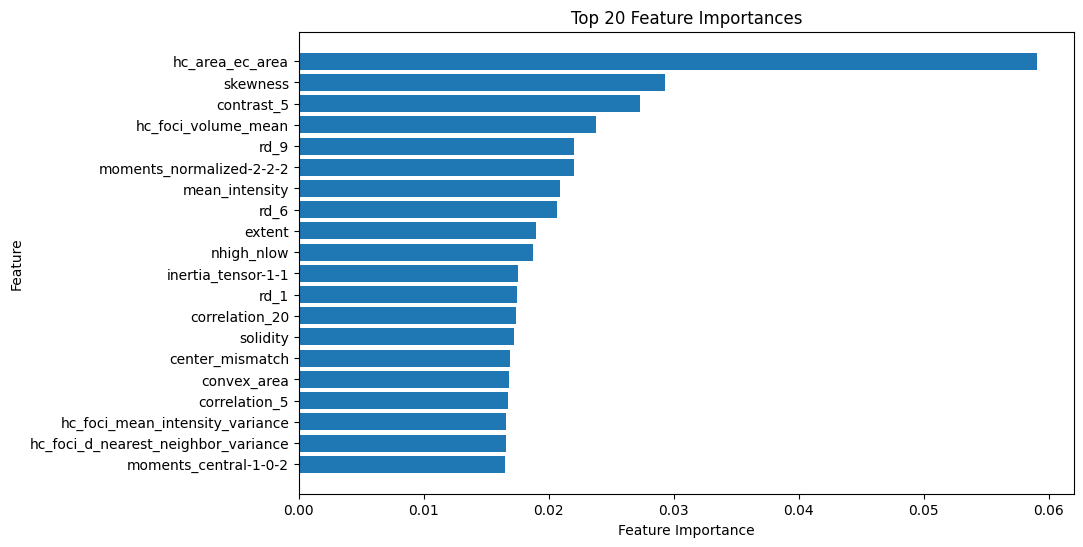

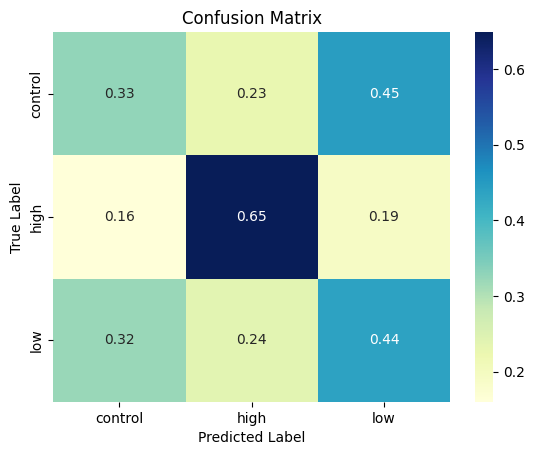

In [14]:
all_possible_rfc(df_train, 'test', compute_pairs = False, n_jobs=8)

Average Train Accuracy: 1.0
Average Accuracy: 0.7200414781297134


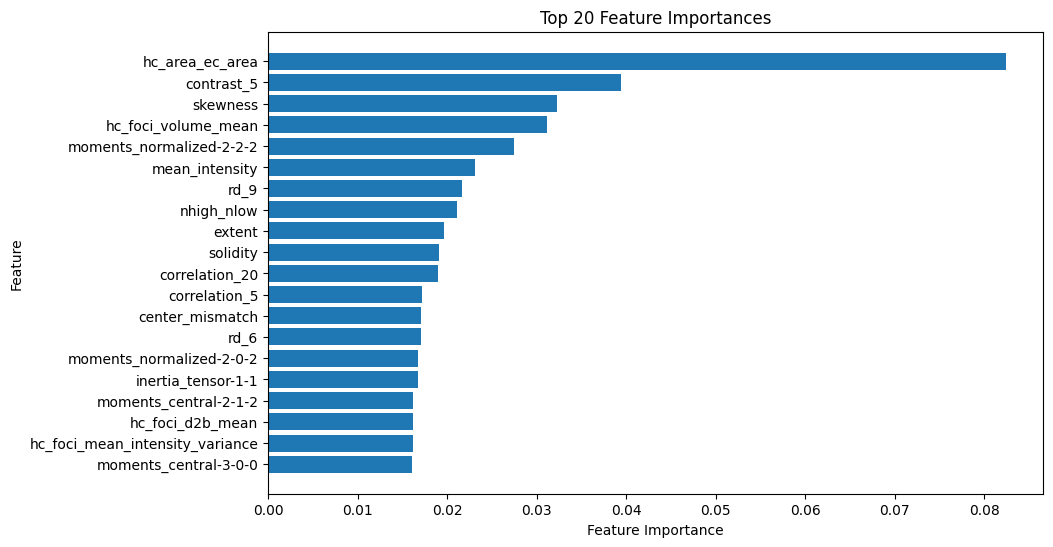

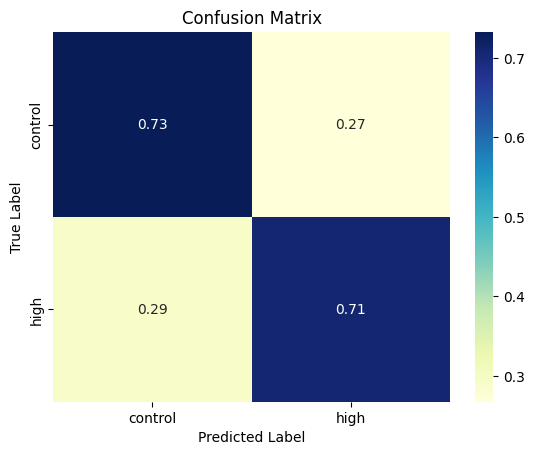

In [21]:
df_train_sub = df_train[df_train['condition'] != 'low']
all_possible_rfc(df_train_sub, 'test', compute_pairs = False, n_jobs=8)

1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
1414       high_2
1404       high_2
1429       high_2
1460       high_2
1567       high_2
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6559139784946236
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
11         high_3
254        high_3
12         high_3
64         high_3
227        high_3
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6833013435700576
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
1023       high_1
856        high_1
898        high_1
889        high_1
1066       high_1
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6538461538461539
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
1435       high_2
1440       high_2
1447       high_2
1457       high_2
1518       high_2
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6277227722772277
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
63         high_3
192        high_3
95         high_3
143        high_3
140        high_3
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6623931623931624
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
886        high_1
976        high_1
869        high_1
855        high_1
859        high_1
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6638115631691649
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
1441       high_2
1543       high_2
1445       high_2
1404       high_2
1374       high_2
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6612903225806451
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
181        high_3
13         high_3
68         high_3
176        high_3
32         high_3
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6621880998080614
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
998        high_1
878        high_1
885        high_1
864        high_1
884        high_1
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6923076923076923
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
1353       high_2
1554       high_2
1559       high_2
1534       high_2
1399       high_2
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6693069306930693
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
84         high_3
252        high_3
265        high_3
150        high_3
144        high_3
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.655982905982906
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
920        high_1
874        high_1
1018       high_1
869        high_1
986        high_1
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6788008565310493
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
1572       high_2
1379       high_2
1442       high_2
1472       high_2
1356       high_2
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6648745519713262
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
35         high_3
69         high_3
171        high_3
238        high_3
231        high_3
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6813819577735125
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
1053       high_1
975        high_1
930        high_1
847        high_1
962        high_1
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6711538461538461
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
1357       high_2
1513       high_2
1341       high_2
1426       high_2
1412       high_2
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6495049504950495
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
225        high_3
245        high_3
6          high_3
204        high_3
126        high_3
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6645299145299145
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
904        high_1
999        high_1
948        high_1
1008       high_1
858        high_1
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6809421841541756
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
1570       high_2
1418       high_2
1524       high_2
1374       high_2
1527       high_2
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6827956989247311
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
163        high_3
45         high_3
39         high_3
140        high_3
105        high_3
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6737044145873321
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
853        high_1
999        high_1
868        high_1
862        high_1
933        high_1
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6692307692307692
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
1580       high_2
1447       high_2
1573       high_2
1368       high_2
1449       high_2
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6495049504950495
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
13         high_3
166        high_3
78         high_3
113        high_3
61         high_3
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6623931623931624
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
914        high_1
1002       high_1
939        high_1
998        high_1
868        high_1
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6723768736616702
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
1442       high_2
1514       high_2
1385       high_2
1533       high_2
1571       high_2
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6774193548387096
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
148        high_3
251        high_3
116        high_3
42         high_3
252        high_3
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6890595009596929
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
955        high_1
923        high_1
886        high_1
911        high_1
896        high_1
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6730769230769231
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
1534       high_2
1396       high_2
1349       high_2
1464       high_2
1488       high_2
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6336633663366337
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
136        high_3
41         high_3
156        high_3
182        high_3
263        high_3
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6666666666666666
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
1040       high_1
861        high_1
864        high_1
933        high_1
1056       high_1
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6788008565310493
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
1518       high_2
1373       high_2
1362       high_2
1540       high_2
1564       high_2
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6720430107526881
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
263        high_3
26         high_3
237        high_3
259        high_3
152        high_3
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.690978886756238
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
908        high_1
911        high_1
1027       high_1
984        high_1
925        high_1
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.698076923076923
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
1438       high_2
1504       high_2
1411       high_2
1368       high_2
1526       high_2
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6475247524752475
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
112        high_3
242        high_3
38         high_3
188        high_3
124        high_3
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.688034188034188
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
847        high_1
886        high_1
942        high_1
996        high_1
1061       high_1
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6852248394004282
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
1524       high_2
1429       high_2
1367       high_2
1371       high_2
1433       high_2
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6505376344086021
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
25         high_3
137        high_3
22         high_3
144        high_3
138        high_3
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6717850287907869
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
917        high_1
861        high_1
834        high_1
969        high_1
906        high_1
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6884615384615385
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
1415       high_2
1519       high_2
1560       high_2
1505       high_2
1479       high_2
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6534653465346535
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
11         high_3
114        high_3
224        high_3
262        high_3
202        high_3
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6709401709401709
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
862        high_1
846        high_1
1010       high_1
1025       high_1
913        high_1
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.69593147751606
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
1428       high_2
1499       high_2
1535       high_2
1543       high_2
1460       high_2
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6648745519713262
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
186        high_3
111        high_3
64         high_3
202        high_3
140        high_3
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6717850287907869
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
939        high_1
972        high_1
992        high_1
1045       high_1
911        high_1
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6865384615384615
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
1387       high_2
1549       high_2
1390       high_2
1581       high_2
1564       high_2
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6752475247524753
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
111        high_3
140        high_3
235        high_3
6          high_3
99         high_3
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.7051282051282052
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
988        high_1
879        high_1
881        high_1
1027       high_1
962        high_1
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6852248394004282
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
1406       high_2
1363       high_2
1534       high_2
1452       high_2
1447       high_2
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6684587813620072
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
211        high_3
239        high_3
238        high_3
162        high_3
131        high_3
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6871401151631478
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
851        high_1
999        high_1
1030       high_1
912        high_1
870        high_1
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6461538461538462
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
1508       high_2
1382       high_2
1375       high_2
1413       high_2
1481       high_2
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6356435643564357
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
170        high_3
216        high_3
217        high_3
185        high_3
241        high_3
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6730769230769231
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
1014       high_1
868        high_1
1048       high_1
996        high_1
981        high_1
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6616702355460385
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
1566       high_2
1340       high_2
1554       high_2
1452       high_2
1561       high_2
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6702508960573477
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
263        high_3
42         high_3
239        high_3
156        high_3
180        high_3
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6660268714011516
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
1004       high_1
1042       high_1
886        high_1
1018       high_1
924        high_1
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6730769230769231
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
1539       high_2
1575       high_2
1568       high_2
1365       high_2
1470       high_2
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6435643564356436
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
182        high_3
49         high_3
195        high_3
55         high_3
20         high_3
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6794871794871795
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
1022       high_1
877        high_1
835        high_1
881        high_1
978        high_1
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6916488222698073
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
1567       high_2
1464       high_2
1470       high_2
1525       high_2
1448       high_2
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6899641577060932
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
91         high_3
33         high_3
146        high_3
32         high_3
171        high_3
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6986564299424184
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
941        high_1
841        high_1
1024       high_1
1069       high_1
996        high_1
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6807692307692308
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
1482       high_2
1405       high_2
1579       high_2
1580       high_2
1467       high_2
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6495049504950495
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
27         high_3
207        high_3
99         high_3
65         high_3
127        high_3
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6730769230769231
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
934        high_1
832        high_1
938        high_1
835        high_1
1011       high_1
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6723768736616702
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
1507       high_2
1430       high_2
1355       high_2
1405       high_2
1485       high_2
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6881720430107527
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
116        high_3
93         high_3
168        high_3
146        high_3
9          high_3
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6737044145873321
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
1040       high_1
961        high_1
964        high_1
918        high_1
1066       high_1
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.65
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
1390       high_2
1368       high_2
1421       high_2
1376       high_2
1450       high_2
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6297029702970297
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
32         high_3
52         high_3
203        high_3
95         high_3
220        high_3
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6623931623931624
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
984        high_1
917        high_1
985        high_1
872        high_1
951        high_1
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6809421841541756
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
1509       high_2
1471       high_2
1554       high_2
1439       high_2
1574       high_2
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6702508960573477
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
127        high_3
40         high_3
34         high_3
60         high_3
157        high_3
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6948176583493282
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
842        high_1
1040       high_1
1032       high_1
1046       high_1
1055       high_1
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6384615384615384
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
1416       high_2
1461       high_2
1501       high_2
1401       high_2
1362       high_2
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6455445544554456
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
172        high_3
31         high_3
42         high_3
166        high_3
79         high_3
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6538461538461539
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
945        high_1
1020       high_1
1009       high_1
890        high_1
1059       high_1
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.683083511777302
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
1576       high_2
1395       high_2
1454       high_2
1354       high_2
1517       high_2
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6397849462365591
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
178        high_3
6          high_3
118        high_3
272        high_3
201        high_3
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6621880998080614
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
864        high_1
936        high_1
1021       high_1
940        high_1
870        high_1
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6673076923076923
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
1376       high_2
1574       high_2
1554       high_2
1377       high_2
1561       high_2
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6356435643564357
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
121        high_3
236        high_3
206        high_3
227        high_3
166        high_3
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6602564102564102
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
931        high_1
1028       high_1
869        high_1
1033       high_1
1064       high_1
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6723768736616702
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
1497       high_2
1574       high_2
1501       high_2
1536       high_2
1452       high_2
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6899641577060932
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
120        high_3
230        high_3
201        high_3
71         high_3
54         high_3
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6871401151631478
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
1009       high_1
1016       high_1
1065       high_1
951        high_1
836        high_1
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6942307692307692
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
1512       high_2
1378       high_2
1385       high_2
1367       high_2
1514       high_2
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6415841584158416
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
147        high_3
238        high_3
25         high_3
88         high_3
10         high_3
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6645299145299145
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
996        high_1
966        high_1
950        high_1
1012       high_1
1059       high_1
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6895074946466809
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
1379       high_2
1543       high_2
1439       high_2
1582       high_2
1516       high_2
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6774193548387096
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
204        high_3
184        high_3
115        high_3
38         high_3
241        high_3
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6871401151631478
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
1001       high_1
976        high_1
857        high_1
927        high_1
925        high_1
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6461538461538462
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
1349       high_2
1482       high_2
1473       high_2
1579       high_2
1412       high_2
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6376237623762376
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
185        high_3
178        high_3
169        high_3
213        high_3
37         high_3
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6538461538461539
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
876        high_1
1050       high_1
843        high_1
1006       high_1
905        high_1
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.683083511777302
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
1356       high_2
1529       high_2
1397       high_2
1461       high_2
1363       high_2
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6845878136200717
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
115        high_3
193        high_3
124        high_3
199        high_3
237        high_3
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6756238003838771
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
882        high_1
1068       high_1
937        high_1
986        high_1
851        high_1
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.7057692307692308
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
1519       high_2
1363       high_2
1394       high_2
1535       high_2
1416       high_2
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6217821782178218
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
33         high_3
157        high_3
131        high_3
113        high_3
274        high_3
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6581196581196581
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
995        high_1
860        high_1
939        high_1
975        high_1
932        high_1
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.683083511777302
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
1367       high_2
1377       high_2
1482       high_2
1469       high_2
1486       high_2
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6666666666666666
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
181        high_3
52         high_3
218        high_3
224        high_3
131        high_3
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.7005758157389635
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
949        high_1
830        high_1
935        high_1
952        high_1
836        high_1
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6269230769230769
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
1525       high_2
1362       high_2
1566       high_2
1512       high_2
1490       high_2
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6455445544554456
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
156        high_3
184        high_3
131        high_3
19         high_3
171        high_3
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6752136752136753
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
1048       high_1
989        high_1
983        high_1
1054       high_1
912        high_1
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6852248394004282
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
1508       high_2
1443       high_2
1341       high_2
1365       high_2
1377       high_2
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6612903225806451
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
66         high_3
32         high_3
154        high_3
92         high_3
60         high_3
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6928982725527831
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
869        high_1
997        high_1
874        high_1
1069       high_1
933        high_1
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6673076923076923
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
1561       high_2
1479       high_2
1366       high_2
1497       high_2
1560       high_2
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6475247524752475
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
222        high_3
188        high_3
170        high_3
95         high_3
194        high_3
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6709401709401709
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
946        high_1
915        high_1
1027       high_1
857        high_1
1000       high_1
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6916488222698073
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
1533       high_2
1554       high_2
1393       high_2
1343       high_2
1389       high_2
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6559139784946236
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
168        high_3
19         high_3
202        high_3
236        high_3
62         high_3
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6871401151631478
1835    control_3
1836    control_3
1837    control_3
1838    control_3
1839    control_3
          ...    
901        high_1
1070       high_1
942        high_1
968        high_1
1024       high_1
Name: condition, Length: 448, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6519230769230769
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
1569       high_2
1565       high_2
1515       high_2
1570       high_2
1367       high_2
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6356435643564357
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
145        high_3
123        high_3
142        high_3
264        high_3
151        high_3
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6645299145299145
2059    control_2
2060    control_2
2061    control_2
2062    control_2
2063    control_2
          ...    
935        high_1
1024       high_1
863        high_1
1039       high_1
1017       high_1
Name: condition, Length: 553, dtype: object


/tmp/ipykernel_444275/720628995.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])


Train Score: 1.0
Test Score: 0.6937901498929336


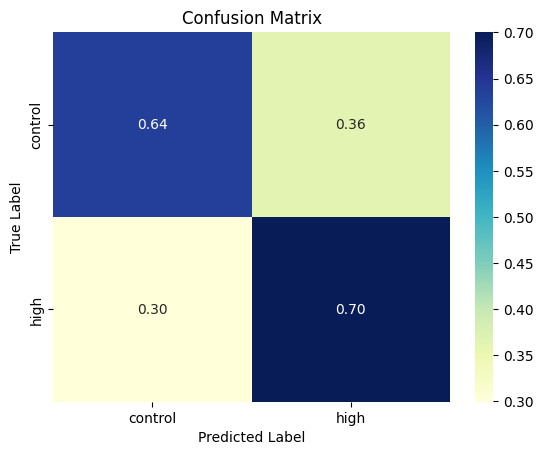

Total Score: 0.6690055074569834


In [16]:
#training on one control, random sample of two highs same size of control and predicting on second control and third high
# -> score slightly lower than when only predicting on high (assuming due to additional bias and since model hasn't seen any bias of control, but of high)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

replicates = [1,2,3,1,2,3]
replicates_c = [2,3,2,3]
scores = []
summed_cm = None

for r in range(20):
    for j in range(1,3):
        for i in range(3):
            df = pd.read_pickle('dataframe_dropped.pkl')
        
            #print(f'Train:high_{replicates[i]},high_{replicates[i+1]}, Test:high_{replicates[i+2]}')
            
            df_control = df[df['condition'].isin([f'control_{replicates_c[j]}'])]
            df_high1 = df[df['condition'].isin([f'high_{replicates[i]}'])].sample(df_control.shape[0]//2)
            df_high2 = df[df['condition'].isin([f'high_{replicates[i+1]}'])].sample(df_control.shape[0]//2)
            
            df_train = pd.concat([df_control,df_high1, df_high2], axis = 0)
            df_pred = df[df['condition'].isin([f'control_{replicates_c[j+1]}', f'high_{replicates[i+2]}'])]
            #df_pred = df_pred.sample(df_pred.shape[0]//2)
    
            print(df_train.condition)
        
            df_train['condition'] = df_train['condition'].apply(lambda x: x.rsplit('_')[0])
            df_pred['condition'] = df_pred['condition'].apply(lambda x: x.rsplit('_')[0])
        
            
            columns = df_train.columns[0:-1]
            X_train = df_train[columns].to_numpy()
            y_train = df_train.condition.to_numpy()
            
            X_test = df_pred[columns].to_numpy()
            y_test = df_pred.condition.to_numpy()
            
            model = RandomForestClassifier(criterion="entropy", n_estimators=100, n_jobs=8)
            
            model.fit(X_train, y_train)
            print(f'Train Score: {model.score(X_train, y_train)}')
            score = model.score(X_test, y_test)
            scores.append(score)
            print(f'Test Score: {score}')
            
            feature_importance_df = pd.DataFrame(model.feature_importances_, columns=["Feature Importance"], index=columns)
            
            #plot_feature_importances(feature_importance_df)
        
            y_pred = model.predict(X_test)
            cm = confusion_matrix(y_test, y_pred)
            
            sum_true_positives = cm.sum(axis=1, keepdims=True)
            normalized_confusion_matrix = cm / sum_true_positives
            
            confusion_matrix_df = pd.DataFrame(normalized_confusion_matrix, columns=model.classes_, index=model.classes_)
                
            #plot_confusion_matrix(confusion_matrix_df)
            
            if summed_cm is None:
                summed_cm = cm
            else:
                summed_cm += cm

sum_true_positives = summed_cm.sum(axis=1, keepdims=True)
normalized_confusion_matrix = summed_cm / sum_true_positives

confusion_matrix_df = pd.DataFrame(normalized_confusion_matrix, columns=model.classes_, index=model.classes_)
plot_confusion_matrix(confusion_matrix_df)

print(f'Total Score: {np.mean(scores)}')


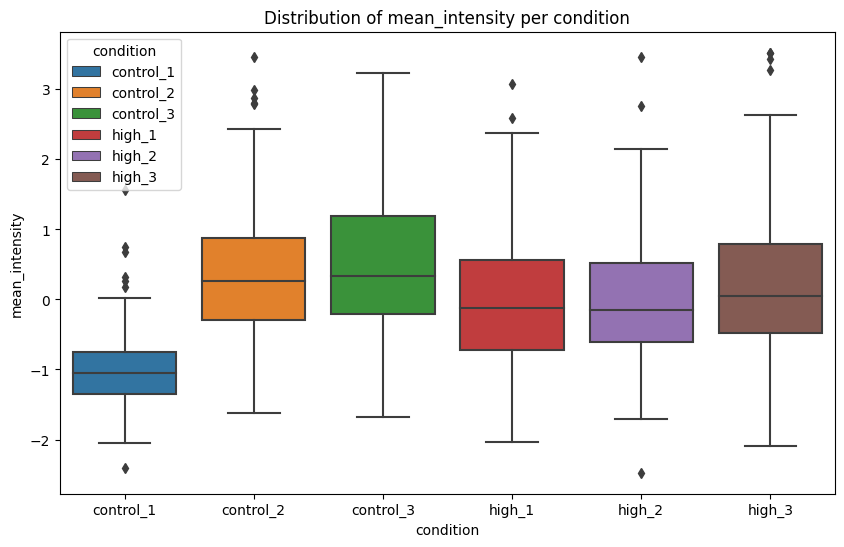

In [9]:
df = pd.read_pickle('dataframe_dropped.pkl')
plt.figure(figsize=(10,6))
df['condition'] = pd.Categorical(df['condition'], categories=['control_1', 'control_2', 'control_3','high_1', 'high_2', 'high_3'])
sns.boxplot(data=df, x='condition', y='mean_intensity', hue='condition', dodge=False)
plt.title('Distribution of mean_intensity per condition')
plt.show()

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

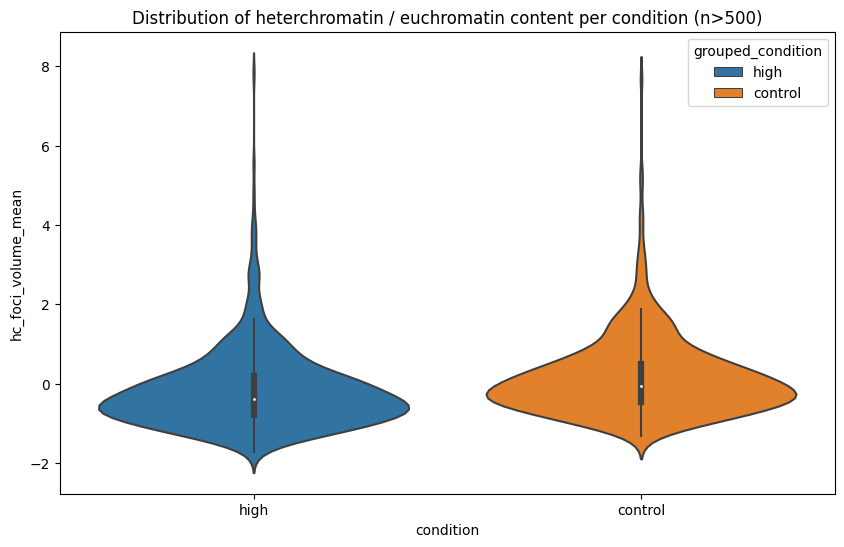

Minimum size of the grouped conditions: 501


In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the DataFrame
df = pd.read_pickle('dataframe_dropped.pkl')

# Group the conditions
condition_mapping = {
    'control_2': 'control',
    'control_3': 'control',
    'high_1': 'high',
    'high_2': 'high',
    'high_3': 'high'
}
df['grouped_condition'] = df['condition'].map(condition_mapping)
df.to_pickle('df_grouped.pkl')

# Find the minimum size of the groups
group_sizes = df['grouped_condition'].value_counts()
min_size = group_sizes.min()

# Plot the data
plt.figure(figsize=(10, 6))
df['condition'] = pd.Categorical(df['condition'], categories=['control_2', 'control_3', 'high_1', 'high_2', 'high_3'])
sns.violinplot(data=df, x='grouped_condition', y='hc_foci_volume_mean', hue='grouped_condition', dodge=False)
plt.title(f'Distribution of heterchromatin / euchromatin content per condition (n>{round(min_size, -1)})')
plt.xlabel('condition')
plt.show()

print(f"Minimum size of the grouped conditions: {min_size}")


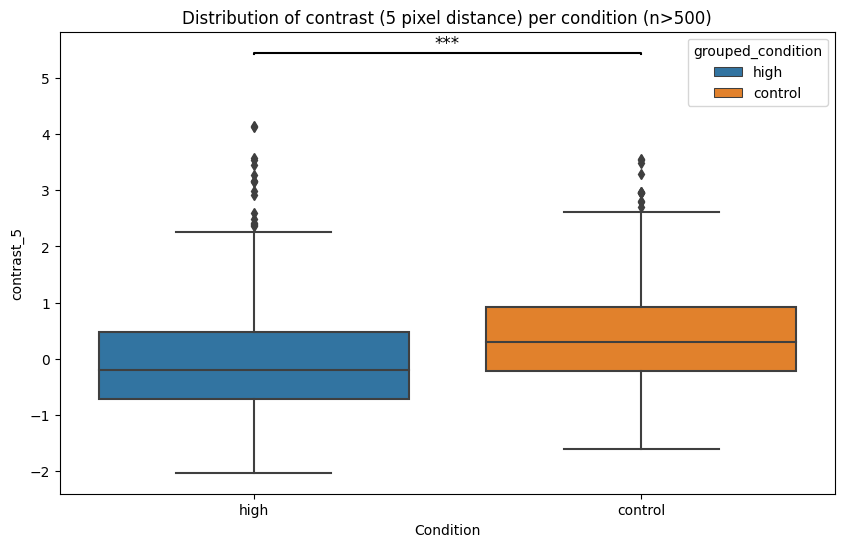

Minimum size of the grouped conditions: 501
Mann-Whitney U test p-value: 4.756677179570958e-21


In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

# Load the dataframe
df = pd.read_pickle('df_grouped.pkl')

feature = 'contrast_5'

# Define the groups
control = df[df['grouped_condition'] == 'control'][feature]
high = df[df['grouped_condition'] == 'high'][feature]

# Perform the Mann-Whitney U test
u_statistic, p_value = stats.mannwhitneyu(control, high, alternative='two-sided')
p_value_adjusted = p_value * df.shape[1]

output_filename = f"{feature}_results.txt"
with open(output_filename, 'w') as f:
    f.write(f"Feature: {feature}\n")
    f.write(f"Mann-Whitney U statistic: {u_statistic}\n")
    f.write(f"Mann-Whitney U test p-value: {p_value_adjusted}\n")

# Define a function to get significance stars
def get_significance_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'  # not significant

# Get the stars for the p-value
stars = get_significance_stars(p_value)

# Find the minimum size of the groups
group_sizes = df['grouped_condition'].value_counts()
min_size = group_sizes.min()

# Plot the data
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='grouped_condition', y=feature, hue='grouped_condition', dodge=False)

# Add significance bar
x1, x2 = 0, 1  # positions of the two groups to compare
y, h, col = df[feature].max() + 0.1, 0.02, 'k'

plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, stars, ha='center', va='bottom', color=col, fontsize=12)

# Set the plot title and labels
plt.title(f'Distribution of contrast (5 pixel distance) per condition (n>{round(min_size, -1)})')
plt.xlabel('Condition')
plt.show()

print(f"Minimum size of the grouped conditions: {min_size}")
print(f"Mann-Whitney U test p-value: {p_value}")
